In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import glob
import os
from torch.utils.data import Dataset, DataLoader, Subset
import torchvision.transforms.functional as tvF
import sys
sys.path.append("../")
from scripts.cdf import cdf2vlos_and_utc
import random
import matplotlib.pyplot as plt
# from tqdm import tqdm_notebook as tqdm
from tqdm.notebook import tqdm
import torch.nn.functional as F
import seaborn as sns
from ipywidgets import interact

In [2]:
# データの準備
data_dir_list = [
    "/home/miyazaki/Documents_ubuntu/noise_reduction/data/fitacf/hok/2017",
    "/home/miyazaki/Documents_ubuntu/noise_reduction/data/fitacf/hok/2018",
    "/home/miyazaki/Documents_ubuntu/noise_reduction/data/fitacf/hok/2019",
    "/home/miyazaki/Documents_ubuntu/noise_reduction/data/fitacf/hok/2020",
    "/home/miyazaki/Documents_ubuntu/noise_reduction/data/fitacf/kod/2021",
    ]

data_path_list = []
for data_dir in data_dir_list:
    data_path_list += glob.glob(data_dir+"/*.cdf")

random.seed(0)
random.shuffle(data_path_list)

train_size = int(len(data_path_list)*0.8)
valid_size = int(len(data_path_list)*0.1)
test_size = len(data_path_list) - train_size - valid_size

train_data_path_list = data_path_list[:train_size]
valid_data_path_list = data_path_list[train_size:train_size+valid_size]
test_data_path_list = data_path_list[train_size+valid_size:]

print(f"train_size: {len(train_data_path_list)}\nvalid_size: {len(valid_data_path_list)}\ntest_size: {len(test_data_path_list)}")


train_size: 667
valid_size: 83
test_size: 84


In [3]:
data, _ = cdf2vlos_and_utc(data_path_list[0])

In [4]:
data_min = 0
data_max = 0
for data_path in tqdm(data_path_list):
    data_, _ = cdf2vlos_and_utc(data_path)
    data_min = min(data_min, data_.min())
    data_max = max(data_max, data_[data_!=10000].max())

  0%|          | 0/834 [00:00<?, ?it/s]

### creating dataset

In [5]:
class MyDataset(Dataset):
    def __init__(self, data_path_list, chunk_size, data_min=None, data_max=None):
        super(MyDataset, self).__init__()
        self.data_path_list = data_path_list
        self.h_max, self.w_max = self._find_hmax_and_wmax()

        self.chunk_size = chunk_size

        self.data_min = data_min
        self.data_max = data_max


    def _find_hmax_and_wmax(self):
        h_max = 0
        w_max = 0

        for data_path in self.data_path_list:
            data, _ = cdf2vlos_and_utc(data_path)
            h_max = max(h_max, data.shape[0])
            w_max = max(w_max, data.shape[1])

        return h_max, w_max


    def _padding(self, data):
        # h_max = self.h_max
        # w_max = self.w_max
        target_h = 110
        target_w = self.chunk_size

        height, width = data.shape[:2]

        target_size = (target_h, target_w)

        padding_height = (target_size[0] - height)/2
        padding_width = (target_size[1] - width)/2
        value = 1.0000000e+04

        if padding_height.is_integer():
            top = bottom = int(padding_height)
        else:
            top = int(padding_height)
            bottom = top + 1
        if padding_width.is_integer():
            left = right = int(padding_width)
        else:
            left = int(padding_width)
            right = left + 1

        data = np.pad(data, [(top, bottom), (left, right)], 'constant', constant_values=(value, value))

        return data


    def _get_data(self, index):
        if index == 0:
            self.file_index = 0
            self.finished = True

        if self.finished:
            self.chunk_index = 0
            data_path = self.data_path_list[self.file_index]
            self.data, _ = cdf2vlos_and_utc(data_path)
            self.splited_data = np.split(self.data, self.chunk_size, axis=0)
            self.splited_data = [self.data[:,i:i+self.chunk_size] for i in range(0, self.data.shape[1], self.chunk_size)]
            
        else:
            self.chunk_index += 1

        if self.chunk_index == len(self.splited_data)-1 or self.splited_data[self.chunk_index].shape[1] < self.chunk_size:
            self.finished = True
            self.file_index += 1

            return self._padding(self.splited_data[self.chunk_index])
        
        else:
            self.finished = False

            return self.splited_data[self.chunk_index]


    def _normalize(self, data):
        data[data==10000] = np.nan
        data = (data - self.data_min)/(self.data_max - self.data_min)
        data[np.isnan(data)] = 0

        return data


    def __getitem__(self, index):
        # data_path = self.data_path_list[index]
        # data, _ = cdf2vlos_and_utc(data_path)
        # data = self._padding(data)
        data = self._get_data(index)
        data = self._normalize(data)
        # print("datashape",data.shape)

        data = tvF.to_tensor(data)
        
        return data
    

    def __len__(self):
        length = 0
        for data_path in self.data_path_list:
            data, _ = cdf2vlos_and_utc(data_path)
            length += data.shape[1]//self.chunk_size
            if data.shape[1]%self.chunk_size != 0:
                length += 1

        return length

In [6]:
class StandardScalerSubset(Subset):
    def __init__(self, dataset, indices, mean=None, std=None, eps=10**-9):
        super().__init__(dataset=dataset, indices=indices)
        target_tensor = torch.stack([dataset[i] for i in indices])
        target_tensor = target_tensor.to(torch.float32)

        if mean is None:
            self._mean = torch.mean(target_tensor, dim=(0, 2, 3))
        else:
            self._mean = mean
        if std is None:
            self._std = torch.std(target_tensor, dim=(0, 2, 3), unbiased=False)
        else:
            self._std = std
        self._eps = eps
        self.std.apply_(lambda x: max(x, self.eps)) # ゼロ割対策

    def __getitem__(self, idx):
        dataset = self.dataset[self.indices[idx]]
        dataset = (dataset - self.mean) / self.std
        return dataset

    @property
    def mean(self):
        return self._mean

    @property
    def std(self):
        return self._std

    @property
    def eps(self):
        return self._eps

### バッチサイズ、チャンクサイズ

In [7]:
def load_dataset(data_path_list, batch_size, shuffle, chunk_size, mean=None, std=None, data_min=None, data_max=None):
    dataset = MyDataset(data_path_list, chunk_size, data_min=data_min, data_max=data_max)
    print(len(dataset))
    # standart_scaler_subset = StandardScalerSubset(dataset, list(range(len(dataset))), mean=mean, std=std)
    # mean = standart_scaler_subset.mean
    # std = standart_scaler_subset.std

    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=0)
    return dataloader, mean, std

batch_size = 256
chunk_size = 110

train_loader, mean, std = load_dataset(train_data_path_list, batch_size=batch_size, chunk_size=chunk_size, shuffle=False, data_min=data_min, data_max=data_max)
valid_loader, _, _ = load_dataset(valid_data_path_list, batch_size=batch_size, chunk_size=chunk_size, shuffle=False, mean=mean, std=std, data_min=data_min, data_max=data_max)
test_loader, _, _ = load_dataset(test_data_path_list, batch_size=batch_size, chunk_size=chunk_size, shuffle=False, mean=mean, std=std, data_min=data_min, data_max=data_max)

130231
16028
15690


In [8]:
def show_data(data):
    # mask=data==1.0000000e+04
    fig, ax = plt.subplots(figsize=(10,2))
    # sns.heatmap(data, cmap="jet", mask=mask, vmax=500 ,vmin=-500)
    sns.heatmap(data, cmap="jet")
    ax.invert_yaxis()
    ax.set(ylabel='rgate_no_1')
    ax.spines['right'].set_visible(True)
    ax.spines['top'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.collections[0].colorbar.set_label('Doppler velocity[m/s]')
    # ax.set(xticklabels=[])
    # ax[0].tick_params(bottom=False)
    # idxs = [int(xtick) for xtick in ax.get_xticks()]
    # xlabels = [timestamp[idx] for idx in idxs]
    # ax.set_xticklabels(xlabels)
    ax.set(xlabel='epoch')
    # plt.subplots_adjust(hspace=0.08)
    plt.show()

### data showing

In [9]:
dataiter = iter(train_loader)
datas = next(dataiter)
datas = datas.numpy()

fig = plt.figure(figsize=(25, 4))

def interact_func(idx):
    show_data(datas[idx].transpose(1,2,0).reshape(-1, chunk_size))

interact(interact_func, idx=range(datas.shape[0]))



<Figure size 2500x400 with 0 Axes>

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.interact_func(idx)>

In [10]:
# dataiter = iter(valid_loader)
# datas = next(dataiter)
# datas = datas.numpy()

# fig = plt.figure(figsize=(25, 4))
# def interact_func(idx):
#     show_data(datas[idx].transpose(1,2,0).reshape(-1, chunk_size))

# interact(interact_func, idx=range(datas.shape[0]))

### model

### UNet

In [11]:
class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        """Initializes U-Net."""

        super(UNet, self).__init__()

        # Layers: enc_conv0, enc_conv1, pool1
        self._block1 = nn.Sequential(
            nn.Conv2d(in_channels, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(48, 48, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))

        # Layers: enc_conv(i), pool(i); i=2..5
        self._block2 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2))

        # Layers: enc_conv6, upsample5
        self._block3 = nn.Sequential(
            nn.Conv2d(48, 48, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(48, 48, 3, stride=2, padding=1, output_padding=1))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_conv5a, dec_conv5b, upsample4
        self._block4 = nn.Sequential(
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 4, stride=2, padding=1, output_padding=1))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_deconv(i)a, dec_deconv(i)b, upsample(i-1); i=4..2
        self._block5 = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 4, stride=2, padding=1, output_padding=1))
            #nn.Upsample(scale_factor=2, mode='nearest'))

        # Layers: dec_conv1a, dec_conv1b, dec_conv1c,
        self._block6 = nn.Sequential(
            nn.Conv2d(96 + in_channels, 64, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, out_channels, 3, stride=1, padding=1),
            # nn.LeakyReLU(0.1))
            # nn.Sigmoid())
            nn.Tanh())
        
        self._block7 = nn.Sequential(
            nn.Conv2d(144, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(96, 96, 3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(96, 96, 4, stride=2, padding=1, output_padding=0))
        
        # Initialize weights
        self._init_weights()


    def _init_weights(self):
        """Initializes weights using He et al. (2015)."""

        for m in self.modules():
            if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight.data)
                m.bias.data.zero_()


    def forward(self, x):
        """Through encoder, then decoder by adding U-skip connections. """

        # # Encoder
        # pool1 = self._block1(x)
        # pool2 = self._block2(pool1)
        # pool3 = self._block2(pool2)

        # # Decoder
        # upsample3 = self._block3(pool3)
        # concat3 = torch.cat((upsample3, pool2), dim=1)
        # upsample2 = self._block4(concat3)
        # concat2 = torch.cat((upsample2, pool1), dim=1)
        # upsample1 = self._block5(concat2)
        # concat1 = torch.cat((upsample1, x), dim=1)

        # Encoder
        pool1 = self._block1(x)
        pool2 = self._block2(pool1)
        pool3 = self._block2(pool2)
        pool4 = self._block2(pool3)
        pool5 = self._block2(pool4)

        # Decoder
        upsample5 = self._block3(pool5)
        concat5 = torch.cat((upsample5, pool4), dim=1)
        upsample4 = self._block4(concat5)
        concat4 = torch.cat((upsample4, pool3), dim=1)
        upsample3 = self._block5(concat4)
        concat3 = torch.cat((upsample3, pool2), dim=1)
        upsample2 = self._block5(concat3)
        concat2 = torch.cat((upsample2, pool1), dim=1)
        upsample1 = self._block7(concat2)
        concat1 = torch.cat((upsample1, x), dim=1)

        # Final activation
        return self._block6(concat1)


### CAE

In [12]:
# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()
#         ## encoder layers ##
#         # conv layer (depth from 3 --> 16), 3x3 kernels
#         self.conv1 = nn.Conv2d(1, 16, 3, padding=1)  
#         # conv layer (depth from 16 --> 4), 3x3 kernels
#         self.conv2 = nn.Conv2d(16, 4, 3, padding=1)
#         # pooling layer to reduce x-y dims by two; kernel and stride of 2
#         self.pool = nn.MaxPool2d(2, 2)
        
#         ## decoder layers ##
#         ## a kernel of 2 and a stride of 2 will increase the spatial dims by 2
#         self.t_conv1 = nn.ConvTranspose2d(4, 16, 3, stride=2)
#         self.t_conv2 = nn.ConvTranspose2d(16, 1, 2, stride=2)

#     def forward(self, x):
#         ## encode ##
#         # add hidden layers with relu activation function
#         # and maxpooling after
#         x = F.relu(self.conv1(x))
#         x = self.pool(x)
#         # add second hidden layer
#         x = F.relu(self.conv2(x))
#         x = self.pool(x)  # compressed representation
        
#         ## decode ##
#         # add transpose conv layers, with relu activation function
#         x = F.relu(self.t_conv1(x))
#         # output layer (with sigmoid for scaling from 0 to 1)
#         x = torch.sigmoid(self.t_conv2(x))
                
#         return x

### CAE2

In [13]:
# from torch.autograd import Variable

# class Reshape(nn.Module):
#     def __init__(self, *args):
#         super(Reshape, self).__init__()
#         self.shape = args
#     def forward(self,x):
#         return x.view(self.shape)

# def get_torch_vars(x):
#     if torch.cuda.is_available():
#         x = x.cuda()
#     return Variable(x)

In [14]:
# class ConvAutoencoder(nn.Module):
#     def __init__(self):
#         super(ConvAutoencoder, self).__init__()
#         self.encoder = nn.Sequential(
#             nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1), nn.Tanh(),
#             nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1), nn.Tanh(),
#             nn.Conv2d(32, 32, kernel_size=3, stride=2, padding=1), nn.Tanh(),
#             nn.Flatten(),
#             nn.Linear(6272, 1024), nn.Tanh(), #6422528
#         )

#         self.decoder = nn.Sequential(
#             nn.Linear(1024, 6272), nn.Tanh(),
#             Reshape(-1, 32, 14, 14),
#             nn.ConvTranspose2d(32, 32, kernel_size=4, stride=2, padding=1, output_padding=0), nn.Tanh(),
#             nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1, output_padding=0), nn.Tanh(),
#             nn.ConvTranspose2d(16, 1, kernel_size=4, stride=2, padding=2, output_padding=0), nn.Sigmoid(),
#         )

#     def forward(self, x):
#         z = self.encoder(x)
#         x_pred = self.decoder(z)
#         return x_pred


In [15]:
import torch.optim.lr_scheduler as lr_scheduler
from lion_pytorch import Lion

### traing settings

In [16]:
num_range = 110
time_len = chunk_size
input_size = num_range*time_len

# model = ConvAutoencoder().to(device="cuda")
model = UNet().to(device="cuda")
# model.load_state_dict(torch.load('./model/'))
# criterion = nn.L1Loss()
criterion = nn.MSELoss()
# optimizer = torch.optim.Adam(model.parameters(), lr=0.03)
optimizer = Lion(model.parameters(), lr=0.0001)
scheduler = lr_scheduler.LinearLR(optimizer, start_factor=1.0, end_factor=0.05, total_iters=100)


In [17]:
from IPython.display import clear_output

### training

In [18]:
# number of epochs to train the model
n_epochs = 100
train_losses = []
valid_losses = []
alpha = 1 # 正則化パラメータ

def calc_li_loss(model, loss):
    # パラメータのL1ノルムを損失関数に足す
    l1 = torch.tensor(0., requires_grad=True)
    for w in model.parameters():
        l1 = l1 + torch.norm(w, 1)
    l1_loss = loss + alpha*l1
    return l1_loss


for epoch in range(1, n_epochs+1):
    train_batch_loss = 0.0
    valid_batch_loss = 0.0
    
    for train_batch, valid_batch in zip(train_loader, valid_loader):
        model.train()
        data = train_batch.to(device="cuda")
        optimizer.zero_grad()
        outputs = model(data)

        train_loss = criterion(outputs, data)
        l1_train_loss = calc_li_loss(model, train_loss)
        l1_train_loss.backward()

        optimizer.step()
        train_batch_loss += l1_train_loss.item()

        model.eval()
        data = valid_batch.to(device="cuda")
        outputs = model(data)
        valid_loss = criterion(outputs, data)
        l1_valid_loss = calc_li_loss(model, valid_loss)
        valid_batch_loss += l1_valid_loss.item()
            
    scheduler.step()

    train_loss_avg = train_batch_loss/len(train_loader)
    valid_loss_avg = valid_batch_loss/len(valid_loader)
    train_losses.append(train_loss_avg)
    valid_losses.append(valid_loss_avg)

    # clear_output(wait=True)
    print(f'Epoch: {epoch}\tTraining Loss: {train_loss_avg:.6f}\tValidation Loss: {valid_loss_avg:.6f}\tlr: {optimizer.param_groups[0]["lr"]:.6f}')

    if epoch % 100 == 0:
        torch.save(model.state_dict(), f'./model/epoch_{epoch}.pth')

        plt.plot(train_losses, label='Training loss')
        plt.savefig(f'./model/train_loss_epoch_{epoch}.png')
        plt.close()

        plt.plot(valid_losses, label='Validation loss')
        plt.savefig(f'./model/valid_loss_epoch_{epoch}.png')
        plt.close()

        plt.plot(train_losses, label='Training loss')
        plt.plot(valid_losses, label='Validation loss')
        plt.legend(frameon=False)
        plt.savefig(f'./model/epoch_{epoch}.png')
        plt.close()

Epoch: 1	Training Loss: 4638.887977	Validation Loss: 37369.396329	lr: 0.000099
Epoch: 2	Training Loss: 3846.841666	Validation Loss: 30986.624349	lr: 0.000098
Epoch: 3	Training Loss: 3173.466225	Validation Loss: 25560.127976	lr: 0.000097
Epoch: 4	Training Loss: 2600.560393	Validation Loss: 20943.359561	lr: 0.000096
Epoch: 5	Training Loss: 2115.353679	Validation Loss: 17033.696212	lr: 0.000095
Epoch: 6	Training Loss: 1707.082012	Validation Loss: 13744.495117	lr: 0.000094
Epoch: 7	Training Loss: 1367.834758	Validation Loss: 11011.828389	lr: 0.000093
Epoch: 8	Training Loss: 1089.528010	Validation Loss: 8770.568483	lr: 0.000092
Epoch: 9	Training Loss: 863.494839	Validation Loss: 6950.704729	lr: 0.000091
Epoch: 10	Training Loss: 682.625214	Validation Loss: 5494.518012	lr: 0.000091
Epoch: 11	Training Loss: 538.583910	Validation Loss: 4335.018268	lr: 0.000090
Epoch: 12	Training Loss: 424.545999	Validation Loss: 3417.170216	lr: 0.000089
Epoch: 13	Training Loss: 335.275336	Validation Loss: 2698.

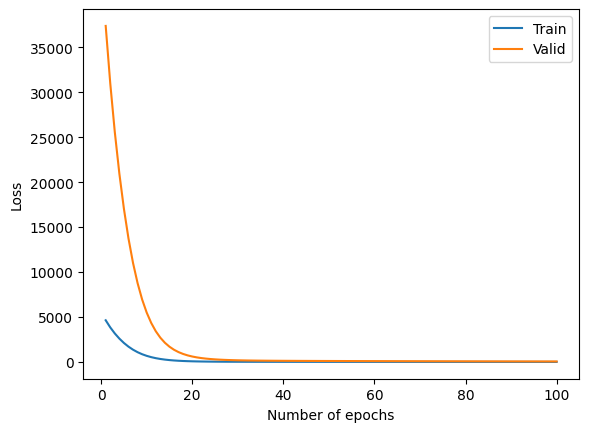

In [19]:
# Plotting the training loss
plt.plot(range(1, n_epochs+1), train_losses, label='Train')
plt.plot(range(1, n_epochs+1), valid_losses, label='Valid')
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [20]:
test_losses = 0
for test_batch in test_loader:
    model.eval()
    data = test_batch.to(device="cuda")
    outputs = model(data)
    test_loss = criterion(outputs, data)
    test_losses += test_loss.item()
print(f"Test loss: {test_losses/len(test_loader):.6f}")

Test loss: 0.042494


### training result

In [21]:
dataiter = iter(train_loader)
datas = next(dataiter)

model.eval()
data = datas.to(device="cuda")
outputs = model(data)

datas = datas.cpu().detach().numpy()
outputs = outputs.cpu().detach().numpy()


fig = plt.figure(figsize=(25, 4))
def interact_func(idx):
    show_data(datas[idx].transpose(1,2,0).reshape(-1, chunk_size))
    show_data(outputs[idx].transpose(1,2,0).reshape(-1, chunk_size))

interact(interact_func, idx=range(datas.shape[0]))

<Figure size 2500x400 with 0 Axes>

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.interact_func(idx)>

### test result

In [22]:
dataiter = iter(test_loader)
datas = next(dataiter)

model.eval()
data = datas.to(device="cuda")
outputs = model(data)

datas = datas.cpu().detach().numpy()
outputs = outputs.cpu().detach().numpy()


fig = plt.figure(figsize=(25, 4))

def interact_func(idx):
    show_data(datas[idx].transpose(1,2,0).reshape(-1, chunk_size))
    show_data(outputs[idx].transpose(1,2,0).reshape(-1, chunk_size))

interact(interact_func, idx=range(datas.shape[0]))

# for idx in np.arange(5):
#     show_data(datas[idx].transpose(1,2,0).reshape(-1,110))
#     show_data(outputs[idx].transpose(1,2,0).reshape(-1,110))

<Figure size 2500x400 with 0 Axes>

interactive(children=(Dropdown(description='idx', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 1…

<function __main__.interact_func(idx)>

In [23]:
outputs[outputs!=0]

array([1.9000072e-06, 1.9000072e-06, 1.9000072e-06, ..., 1.9000072e-06,
       1.9000072e-06, 1.9000072e-06], dtype=float32)